In [ ]:
#1################################################### Please Read This ####################################################
# Make sure to set runtime to T4.It's the first thing to do.
# "train_only.zip" disappears from the /content folder if you change the runtime after uploading it.
# You can upload the dataset to your drive and mount it, but using it directly from the drive may cause slow speed.

In [1]:
#2 Run the cell after uploading train_only.zip following the provided challenge guide pdf.

import zipfile
import os

zip_path = '/content/train_only.zip'
extract_dir = '/content/'

# Unzip the train_only.zip to get train_images_small and train_annotation_small.
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Unzipped to: {os.path.abspath(extract_dir)}")

Unzipped to: /content


In [19]:
#3
import os
import json
import time
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [3]:
#4 Set device to cuda. If the cell outputs "cpu", change the runtime to T4.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
#5 HumanDetectDataset class. Do not change.

class HumanDetectionDataset(Dataset):
    def __init__(self, image_dir, annotation_path, transforms=None):
        self.image_dir = image_dir
        self.transforms = transforms

        # Load annotation json file
        with open(annotation_path, 'r') as f:
            raw_ann = json.load(f)


        from collections import defaultdict
        self.annotations = defaultdict(list)

        # Append bounding boxes for all images.
        for ann in raw_ann:
            self.annotations[ann['file_name']].append(ann['bbox'])

        self.image_files = list(self.annotations.keys())

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        file_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, file_name)
        image = Image.open(img_path).convert("RGB")

        boxes = self.annotations[file_name]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)  # [x, y, w, h]

        # Set boxes as two corner coordinates; left_top & right_bottomm [x1, y1, x2, y2]
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

        target = {
            'boxes': boxes,
            'labels': torch.ones((len(boxes),), dtype=torch.int64)  # 1: person
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target, file_name

In [5]:
#6 Images may differ in size.
# Add padding to right and left of relatively small images to set all images to same size..
# This allows parallel computations using GPU

def collate_fn_with_padding(batch):
    images, targets, filenames = zip(*batch)

    max_h = max(img.shape[1] for img in images)
    max_w = max(img.shape[2] for img in images)

    padded_images = []
    for img in images:
        _, h, w = img.shape
        pad_bottom = max_h - h
        pad_right = max_w - w
        padded = F.pad(img, pad=(0, pad_right, 0, pad_bottom), value=0)
        padded_images.append(padded)

    batch_images = torch.stack(padded_images)
    return batch_images, targets, filenames

In [6]:
#7 Data Augmentation. You may freely design transformation.

########################################################################## ↓↓ You can fix this code ↓↓ ##########################################################################
transform = T.ToTensor()
########################################################################## ↑↑ You can fix this code ↑↑ ##########################################################################

In [7]:
#8 Split the dataset into training and validation sets.
# Note: Final evaluation will be performed on a hidden test dataset.

from torch.utils.data import random_split

train_dataset = HumanDetectionDataset(
    image_dir='/content/train_images_small',
    annotation_path='/content/train_annotation_small.json',
    transforms=transform
)

# Define split ratio
val_ratio = 0.2  # 20% for validation
total_size = len(train_dataset)
val_size = int(total_size * val_ratio)
train_size = total_size - val_size

# Split dataset
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

In [8]:
#9 Create DataLoaders. You may change the batch_size if you want.

########################################################################## ↓↓ You can fix this code ↓↓ ##########################################################################
train_loader = DataLoader(train_subset, batch_size=4, shuffle=True, collate_fn=collate_fn_with_padding, num_workers=2)
########################################################################## ↑↑ You can fix this code ↑↑ ##########################################################################
val_loader = DataLoader(val_subset, batch_size=1, shuffle=True, collate_fn=collate_fn_with_padding, num_workers=2)

In [9]:
#10 Simple HumanDetector example
# You may freely design your own HumanDetector class.
# Tip 1 : "num_boxes" is fixed in the example. Does it have to be fixed?

########################################################################## ↓↓ You can fix this code ↓↓ ##########################################################################
import torch
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

class HumanDetector(torch.nn.Module):
    def __init__(self, weight_path=None, num_classes=2, device='cpu'):
        super().__init__()

        # Load base model
        base_model = fasterrcnn_mobilenet_v3_large_fpn(weights=None, weights_backbone=None)
        in_features = base_model.roi_heads.box_predictor.cls_score.in_features
        base_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

        self.model = base_model.to(device)

        # Load weights if provided
        if weight_path is not None:
            state_dict = torch.load(weight_path, map_location=device)

            # Check if keys need prefix 'model.'
            if not list(state_dict.keys())[0].startswith('model.'):
                # Add prefix to match self.model's state_dict keys
                state_dict = {'model.' + k: v for k, v in state_dict.items()}

            self.load_state_dict(state_dict)

    def forward(self, images):
        outputs = self.model(images)  # List[Dict]
        processed = []

        for output in outputs:
            boxes = output['boxes']
            scores = output['scores']
            boxes_scores = torch.cat([boxes, scores.unsqueeze(1)], dim=1)
            processed.append(boxes_scores)

        return processed


########################################################################## ↑↑ You can fix this code ↑↑ ##########################################################################

In [10]:
#11 Model, optimizer and scheduler.
# You may change the settings.

########################################################################## ↓↓ You can fix this code ↓↓ ##########################################################################

model = fasterrcnn_mobilenet_v3_large_fpn(weights=None,weights_backbone=None)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(
    params,
    lr=0.0005,
    betas=(0.9, 0.999),
    weight_decay=0.0005
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)
########################################################################## ↑↑ You can fix this code ↑↑ ##########################################################################


In [11]:
#12 Calculate Box Intersection over Unions (IoU)

def box_iou(box1, box2):
    area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])

    lt = torch.max(box1[:, None, :2], box2[:, :2])  # [N, M, 2]
    rb = torch.min(box1[:, None, 2:], box2[:, 2:])  # [N, M, 2]
    wh = (rb - lt).clamp(min=0)
    inter = wh[:, :, 0] * wh[:, :, 1]
    union = area1[:, None] + area2 - inter
    return inter / union

In [14]:
#13 Define training. You may design your own loss, and training configurations.

########################################################################## ↓↓ You can fix this code ↓↓ ##########################################################################
def train(model, dataloader, optimizer, scheduler, device, epochs=10):
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        num_batches = 0

        for images, targets, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)  # FasterRCNN computes its own losses
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            total_loss += losses.item()
            num_batches += 1

        scheduler.step()
        avg_loss = total_loss / num_batches if num_batches > 0 else 0.0
        print(f"[Epoch {epoch+1}] Avg Loss: {avg_loss:.4f}")
        torch.save(model.state_dict(), f"none_pretrained_HumanDetection_{epoch}.pt")
        print(f"none_pretrained_HumanDetection_{epoch+1}.pt")


# Train the model
train(model, train_loader, optimizer, lr_scheduler, device, epochs=10)
########################################################################## ↑↑ You can fix this code ↑↑ ##########################################################################

Epoch 1: 100%|██████████| 4000/4000 [16:52<00:00,  3.95it/s]


[Epoch 1] Avg Loss: 0.6605
none_pretrained_HumanDetection_1.pt


Epoch 2: 100%|██████████| 4000/4000 [16:44<00:00,  3.98it/s]


[Epoch 2] Avg Loss: 0.6466
none_pretrained_HumanDetection_2.pt


Epoch 3: 100%|██████████| 4000/4000 [16:41<00:00,  3.99it/s]


[Epoch 3] Avg Loss: 0.6193
none_pretrained_HumanDetection_3.pt


Epoch 4: 100%|██████████| 4000/4000 [16:37<00:00,  4.01it/s]


[Epoch 4] Avg Loss: 0.6096
none_pretrained_HumanDetection_4.pt


Epoch 5: 100%|██████████| 4000/4000 [16:35<00:00,  4.02it/s]


[Epoch 5] Avg Loss: 0.6038
none_pretrained_HumanDetection_5.pt


Epoch 6: 100%|██████████| 4000/4000 [16:34<00:00,  4.02it/s]


[Epoch 6] Avg Loss: 0.5961
none_pretrained_HumanDetection_6.pt


Epoch 7: 100%|██████████| 4000/4000 [16:35<00:00,  4.02it/s]


[Epoch 7] Avg Loss: 0.5954
none_pretrained_HumanDetection_7.pt


Epoch 8: 100%|██████████| 4000/4000 [16:34<00:00,  4.02it/s]


[Epoch 8] Avg Loss: 0.5937
none_pretrained_HumanDetection_8.pt


Epoch 9: 100%|██████████| 4000/4000 [16:34<00:00,  4.02it/s]


[Epoch 9] Avg Loss: 0.5926
none_pretrained_HumanDetection_9.pt


Epoch 10: 100%|██████████| 4000/4000 [16:36<00:00,  4.01it/s]


[Epoch 10] Avg Loss: 0.5922
none_pretrained_HumanDetection_10.pt


In [ ]:
#14 Save the trained model.
# Make sure to download the checkpoint before leaving Colab.
torch.save(model.state_dict(), "HumanDetection.pt")
print("Model saved as HumanDetection.pt")

Model saved as 2022171087_HumanDetection.pt


In [20]:
#15 Evaluation with validation dataloader.
# Do NOT change the code here.
# Note: Final evaluation will be performed with same code as below on a hidden test dataset.

@torch.no_grad()
def evaluate_map(model, dataloader, iou_threshold=0.5, max_detections=10, visualize_count=5):
    model.eval()
    all_precisions = []

    # Prepare subplot for visualizing predictions and ground truth
    fig, axs = plt.subplots(1, visualize_count, figsize=(visualize_count * 5, 5))
    if visualize_count == 1:
        axs = [axs]

    vis_done = 0

    start_time = time.time()

    # Iterate through validation dataset
    for batch_idx, (images, targets, filenames) in enumerate(tqdm(dataloader)):
        images = images.to(device)
        outputs = model(images)
        outputs = outputs[0].cpu()  # Assuming batch size = 1

        pred_boxes = outputs[:, :4]  # Predicted bounding boxes
        pred_scores = torch.sigmoid(outputs[:, 4])  # Objectness scores (after sigmoid)

        # Sort predictions by objectness score (descending)
        sorted_idx = pred_scores.argsort(descending=True)
        pred_boxes = pred_boxes[sorted_idx]
        pred_scores = pred_scores[sorted_idx]

        gt_boxes = targets[0]['boxes']  # Ground truth boxes
        matched_gt = set()  # Track matched GT indices

        tps, fps = [], []  # Lists for true positives and false positives

        # Evaluate top-k predictions
        for pred_box in pred_boxes[:max_detections]:
            if len(gt_boxes) == 0:
                break
            ious = box_iou(pred_box.unsqueeze(0), gt_boxes).squeeze(0)
            max_iou, max_idx = ious.max(0)
            if max_iou >= iou_threshold and max_idx.item() not in matched_gt:
                tps.append(1)  # True positive
                fps.append(0)
                matched_gt.add(max_idx.item())
            else:
                tps.append(0)
                fps.append(1)  # False positive

        if len(tps) == 0:
            continue  # No predictions, skip

        # Compute cumulative precision and recall
        tps_cum = torch.tensor(tps).cumsum(0)
        fps_cum = torch.tensor(fps).cumsum(0)
        precisions = tps_cum / (tps_cum + fps_cum + 1e-6)
        recalls = tps_cum / (len(gt_boxes) + 1e-6)

        # 11-point interpolated Average Precision (AP)
        ap = 0.0
        for r in torch.linspace(0, 1, 11):
            p = precisions[recalls >= r].max() if (recalls >= r).any() else 0
            ap += p / 11
        all_precisions.append(ap)

        # --- Visualization for first N images ---
        if vis_done < visualize_count:
            ax = axs[vis_done]
            img = images[0].cpu()
            filename = filenames[0]

            ax.imshow(img.permute(1, 2, 0))  # Convert from CHW to HWC
            ax.set_title(f"{filename}", fontsize=10)

            # Draw ground truth boxes (green)
            for box in gt_boxes:
                x1, y1, x2, y2 = box
                w, h = x2 - x1, y2 - y1
                rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='green', facecolor='none')
                ax.add_patch(rect)

            # Draw best predicted box (red)
            best_idx = pred_scores.argmax()
            best_box = pred_boxes[best_idx]
            x1, y1, x2, y2 = best_box
            w, h = x2 - x1, y2 - y1
            rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

            ax.axis('off')
            vis_done += 1
    print(f'Total time is : {time.time()-start_time}')
    plt.tight_layout()
    plt.show()

    # Compute mean Average Precision (mAP) over all images
    mAP = sum(all_precisions) / len(all_precisions) if all_precisions else 0.0
    print(f"mAP@{iou_threshold:.2f}: {mAP:.4f}")

100%|██████████| 4000/4000 [01:59<00:00, 33.47it/s]


Total time is : 119.50179505348206


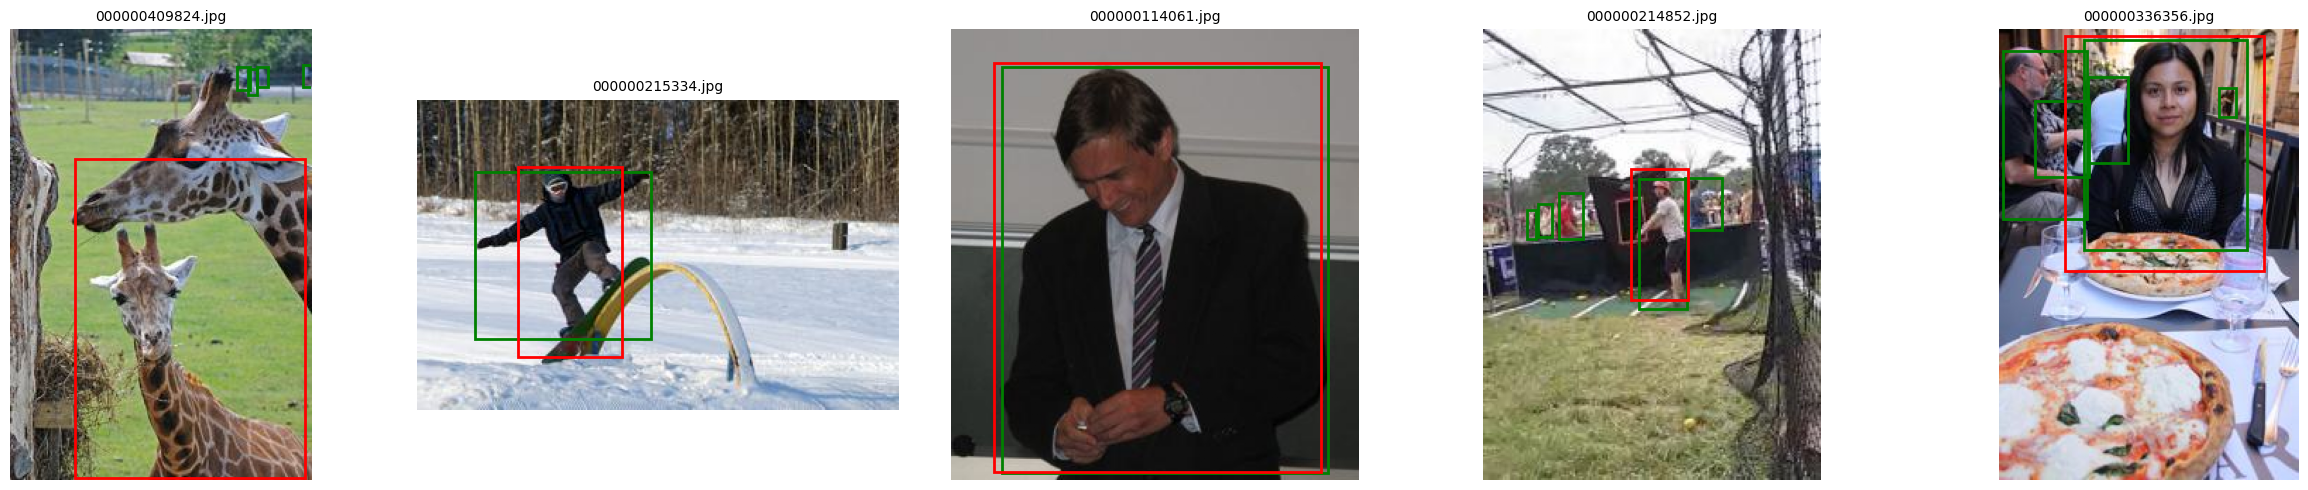

mAP@0.50: 0.5431


In [ ]:
# #16 Load Model

model = HumanDetector('HumanDetection.pt', device=device).to(device)
# Evaluate on validation set
evaluate_map(model, val_loader, iou_threshold=0.5, max_detections=10, visualize_count=5)

